# Executive Summary of Code
Flow of the Code
- Started by importing the data from kaggle to google drive. 
- Adapted code from RoyMachineLearning on Github to reduce the RAM resources given the size of the files.
- The imported data was then read into dataframes
- The dataframes were visualised and quickly analysed to aid feature selection
- The selected features were then used to train a logistic model
- The logistic model was used to predict fraudlent and non-fraudlent transactions

# Mounting drive and Connecting to Kaggle

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# from google.colab import files
# files.upload()

In [0]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# !kaggle datasets list

In [0]:
# # Downloading Fraud detection data from Kaggle
# !kaggle competitions download -c ieee-fraud-detection -p "/content/drive/My Drive/Colab Notebooks/MakeMoneyWithMachineLearning/Week3"

In [0]:
# import os
# os.chdir("/content/drive/My Drive/Colab Notebooks/MakeMoneyWithMachineLearning/Week3")  #change dir
# !mkdir data
# os.chdir("/content/drive/My Drive/Colab Notebooks/MakeMoneyWithMachineLearning/Week3/data")  #change dir
# !mkdir train  #create a directory named train/
# !mkdir test  #create a directory named test/


In [0]:
# os.chdir("/content/drive/My Drive/Colab Notebooks/MakeMoneyWithMachineLearning/Week3/data")  #change dir

# # Unzip transaction and identity training data into train folder
# !unzip -q train_transaction.csv.zip -d train 
# !unzip -q train_identity.csv.zip -d train

# # Unzip transaction and identity test data into test folder
# !unzip -q test_transaction.csv.zip -d test
# !unzip -q test_identity.csv.zip -d test

# # Unzip sample results data
# !unzip -q sample_submission.csv.zip

## Calling Libraries, declaring functions, storing data in DataFrames

In [0]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import warnings
import multiprocessing


In [0]:
# # Getting Colab PC System Information

# import platform
# print ('\033[1m\033[94mSystem Processor:\033[0m', platform.processor(), '\n')
# print ('\n\033[1m\033[94mThe Disc Info:\033[0m')
# !df -h
# print ('\n\033[1m\033[94mThe CPU Info:\033[0m')
# !cat /proc/cpuinfo
# print ('\n\033[1m\033[94mThe Memory Info:\033[0m')
# !cat /proc/meminfo

In [0]:
# Dataframe Summary
def df_summary(dataframe):
  print('There are {} rows and {} columns\nThe columns are: {} \n\nA summary of the data: \n{} \n\n Some data\n{}'.format(dataframe.shape[0], dataframe.shape[1], dataframe.columns.values, dataframe.describe(),display(dataframe.head(5))))


In [0]:
# Reducing Ram usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
# Importing the data
%%time
warnings.simplefilter('ignore')

path = '/content/drive/My Drive/Colab Notebooks/MakeMoneyWithMachineLearning/Week3/data/'
files = ['sample_submission.csv', 
         'train/train_identity.csv',
         'train/train_transaction.csv',
         'test/test_identity.csv',
         'test/test_transaction.csv']

def load_data(file):
    return reduce_mem_usage(pd.read_csv(path+file))

with multiprocessing.Pool() as pool:
    sample_df, train_id_df, train_trans_df, validate_id_df, validate_trans_df = pool.map(load_data, files)

Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
CPU times: user 2.39 s, sys: 1.75 s, total: 4.14 s
Wall time: 3min 19s


# Analysing the data

In [12]:
# Understanding the data, Quick overview
print ('\033[1m\033[94mAnalysing the Sample Data\033[0m\n')
df_summary(sample_df)

print ('\n\033[1m\033[94mAnalysing the Training Identification Data\033[0m\n')
df_summary(train_id_df)

print ('\n\033[1m\033[94mAnalysing the Training Transaction Data\033[0m\n')
df_summary(train_trans_df)

print ('\n\033[1m\033[94mAnalysing the Testing Identification Data\033[0m\n')
df_summary(validate_id_df)

print ('\n\033[1m\033[94mAnalysing the Testing Transaction Data\033[0m\n')
df_summary(validate_trans_df)

Analysing the Sample Data



,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


There are 506691 rows and 2 columns
The columns are: ['TransactionID' 'isFraud'] 

A summary of the data: 
       TransactionID   isFraud
count   5.066910e+05  506691.0
mean    3.916894e+06       NaN
std     1.462692e+05       0.0
min     3.663549e+06       0.5
25%     3.790222e+06       0.5
50%     3.916894e+06       0.5
75%     4.043566e+06       0.5
max     4.170239e+06       0.5 

 Some data
None

Analysing the Training Identification Data



,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


There are 144233 rows and 41 columns
The columns are: ['TransactionID' 'id_01' 'id_02' 'id_03' 'id_04' 'id_05' 'id_06' 'id_07'
 'id_08' 'id_09' 'id_10' 'id_11' 'id_12' 'id_13' 'id_14' 'id_15' 'id_16'
 'id_17' 'id_18' 'id_19' 'id_20' 'id_21' 'id_22' 'id_23' 'id_24' 'id_25'
 'id_26' 'id_27' 'id_28' 'id_29' 'id_30' 'id_31' 'id_32' 'id_33' 'id_34'
 'id_35' 'id_36' 'id_37' 'id_38' 'DeviceType' 'DeviceInfo'] 

A summary of the data: 
       TransactionID     id_01        id_02  ...      id_25       id_26    id_32
count   1.442330e+05  144233.0  140872.0000  ...  5132.0000  5163.00000  77586.0
mean    3.236329e+06       NaN  174716.9375  ...        inf         inf      NaN
std     1.788496e+05       0.0  159650.0000  ...    97.4375    32.09375      0.0
min     2.987004e+06    -100.0       1.0000  ...   100.0000   100.00000      0.0
25%     3.077142e+06     -10.0   67992.0000  ...   321.0000   119.00000     24.0
50%     3.198818e+06      -5.0  125800.5000  ...   321.0000   149.00000     24.0
7

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


There are 141907 rows and 41 columns
The columns are: ['TransactionID' 'id_01' 'id_02' 'id_03' 'id_04' 'id_05' 'id_06' 'id_07'
 'id_08' 'id_09' 'id_10' 'id_11' 'id_12' 'id_13' 'id_14' 'id_15' 'id_16'
 'id_17' 'id_18' 'id_19' 'id_20' 'id_21' 'id_22' 'id_23' 'id_24' 'id_25'
 'id_26' 'id_27' 'id_28' 'id_29' 'id_30' 'id_31' 'id_32' 'id_33' 'id_34'
 'id_35' 'id_36' 'id_37' 'id_38' 'DeviceType' 'DeviceInfo'] 

A summary of the data: 
       TransactionID     id_01          id_02  ...     id_25       id_26    id_32
count   1.419070e+05  141907.0  136976.000000  ...  5039.000  5047.00000  70671.0
mean    3.972166e+06       NaN  192658.687500  ...       inf         inf      NaN
std     1.469966e+05       0.0  182611.234375  ...    86.375    31.90625      0.0
min     3.663586e+06    -100.0       2.000000  ...   100.000   100.00000      8.0
25%     3.859268e+06     -12.5   63339.500000  ...   321.000   137.00000     24.0
50%     4.001774e+06      -5.0  133189.500000  ...   321.000   147.00000    

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.0000,280.000000,0.0000,77.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2636.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.0000,1058.000000,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,282.5000,282.500,282.5000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.9375,183.850006,67.9375,67.949997,67.9375,183.875,67.9375,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 506691 rows and 393 columns
The columns are: ['TransactionID' 'TransactionDT' 'TransactionAmt' 'ProductCD' 'card1'
 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1' 'dist2'
 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7'
 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3' 'M4' 'M5'
 'M6' 'M7' 'M8' 'M9' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10'
 'V11' 'V12' 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22'
 'V23' 'V24' 'V25' 'V26' 'V27' 'V28' 'V29' 'V30' 'V31' 'V32' 'V33' 'V34'
 'V35' 'V36' 'V37' 'V38' 'V39' 'V40' 'V41' 'V42' 'V43' 'V44' 'V45' 'V46'
 'V47' 'V48' 'V49' 'V50' 'V51' 'V52' 'V53' 'V54' 'V55' 'V56' 'V57' 'V58'
 'V59' 'V60' 'V61' 'V62' 'V63' 'V64' 'V65' 'V66' 'V67' 'V68' 'V69' 'V70'
 'V71' 'V72' 'V73' 'V74' 'V75' 'V76' 'V77' 'V78' 'V79' 'V80' 'V81' 'V82'
 'V83' 'V84' 'V85' 'V86' 'V87' 'V88' 'V89' 'V90' 'V91' 'V92' 'V93' 'V94'
 'V

## Merging the data 

- Train data to be merged to facilitate model training and initial tests
- Teste data to be merged to facilitate model validation, after fine tuning. 

In [0]:
# Appropriately Merging training and validation DataFrames 
train_df = pd.merge(train_trans_df, train_id_df,on='TransactionID', how = 'left')
validate_df = pd.merge(validate_trans_df, validate_id_df, on='TransactionID', how = 'left')


In [14]:
print ('\033[1m\033[94mAnalysing the Training Data\033[0m\n')
df_summary(train_df)

Analysing the Training Data



,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


There are 590540 rows and 434 columns
The columns are: ['TransactionID' 'isFraud' 'TransactionDT' 'TransactionAmt' 'ProductCD'
 'card1' 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1'
 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6'
 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5'
 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3'
 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8'
 'V9' 'V10' 'V11' 'V12' 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20'
 'V21' 'V22' 'V23' 'V24' 'V25' 'V26' 'V27' 'V28' 'V29' 'V30' 'V31' 'V32'
 'V33' 'V34' 'V35' 'V36' 'V37' 'V38' 'V39' 'V40' 'V41' 'V42' 'V43' 'V44'
 'V45' 'V46' 'V47' 'V48' 'V49' 'V50' 'V51' 'V52' 'V53' 'V54' 'V55' 'V56'
 'V57' 'V58' 'V59' 'V60' 'V61' 'V62' 'V63' 'V64' 'V65' 'V66' 'V67' 'V68'
 'V69' 'V70' 'V71' 'V72' 'V73' 'V74' 'V75' 'V76' 'V77' 'V78' 'V79' 'V80'
 'V81' 'V82' 'V83' 'V84' 'V85' 'V86' 'V87' 'V88' 'V89' 'V90' 'V91' 'V92'
 'V93

In [15]:
# Comparing data frames
print('Shape of combined training  is {}\nShape of Train Identification ID is {} \nShape of Train Transaction ID is {} \n{} Rows were dropped from the transaction dataframeafter merging \n{} Columns were added to the transaction dataframe after merging'.format(train_df.shape,train_id_df.shape,train_trans_df.shape,(train_trans_df.shape[0]-train_df.shape[0]),(train_trans_df.shape[1]-train_id_df.shape[1])))

Shape of combined training  is (590540, 434)
Shape of Train Identification ID is (144233, 41) 
Shape of Train Transaction ID is (590540, 394) 
0 Rows were dropped from the transaction dataframeafter merging 
353 Columns were added to the transaction dataframe after merging


In [16]:
display(train_df.sample(10))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
287336,3274336,0,7067422,141.00000,W,9540,555.0,150.0,visa,226.0,debit,330.0,87.0,2.0,NaN,gmail.com,NaN,3.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,10.0,3.0,137.0,137.0,0.0,508.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198945,3185945,0,4494795,39.50000,W,10631,360.0,150.0,mastercard,126.0,debit,264.0,87.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516462,3503462,0,13535616,117.00000,W,9112,250.0,150.0,visa,226.0,debit,441.0,87.0,6.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,174.0,174.0,2.0,175.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
551667,3538667,0,14580420,117.00000,W,15063,514.0,150.0,visa,226.0,credit,143.0,87.0,9.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,10.0,1.0,99.0,99.0,56.0,99.0,77.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313193,3300193,0,7787268,107.93750,W,10486,514.0,150.0,mastercard,219.0,credit,485.0,87.0,6.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,2.0,137.0,137.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242854,3229854,0,5767784,97.00000,W,6530,206.0,150.0,mastercard,166.0,debit,123.0,87.0,5.0,NaN,gmail.com,NaN,1.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,6.0,1.0,30.0,30.0,0.0,29.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109192,3096192,0,2148894,100.00000,R,6019,583.0,150.0,visa,226.0,credit,315.0,87.0,NaN,10.0,aol.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,740.0,0.833496,...,-5.0,120346.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,-360.0,Found,Found,166.0,NaN,312.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,edge 15.0,24.0,NaN,match_status:2,T,F,T,T,desktop,Windows
291253,3278253,0,7171152,117.00000,W,6481,111.0,150.0,visa,226.0,debit,337.0,87.0,3.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,58.0,58.0,58.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256245,3243245,0,6131309,43.96875,W,5700,122.0,150.0,mastercard,166.0,debit,494.0,87.0,NaN,NaN,yahoo.com,NaN,4.0,5.0,0.0,0.0,2.0,3.0,0.0,0.0,3.0,0.0,5.0,0.0,6.0,4.0,13.0,13.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382627,3369627,0,9581827,68.93750,W,16560,476.0,150.0,visa,166.0,debit,264.0,87.0,30.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1


A quick overview of the data shows that there are many NaN values. 

It is necessary to drop some columns and keep only those that have few NaN values.

The remaining columns will be used for the Logistic Regression model

In [17]:
# Determing percentage of NaN Values for each column

train_df_nan = (train_df.isnull().sum().sort_values(ascending=False))/len(train_df)*100
train_df_nan = pd.DataFrame({'% Empty':train_df_nan})
display(train_df_nan.head(5))

validate_df_nan = (validate_df.isnull().sum().sort_values(ascending=False))/len(validate_df)*100
validate_df_nan = pd.DataFrame({'% Empty':validate_df_nan})

,% Empty
id_24,99.196159
id_25,99.130965
id_07,99.127070
id_08,99.127070
id_21,99.126393


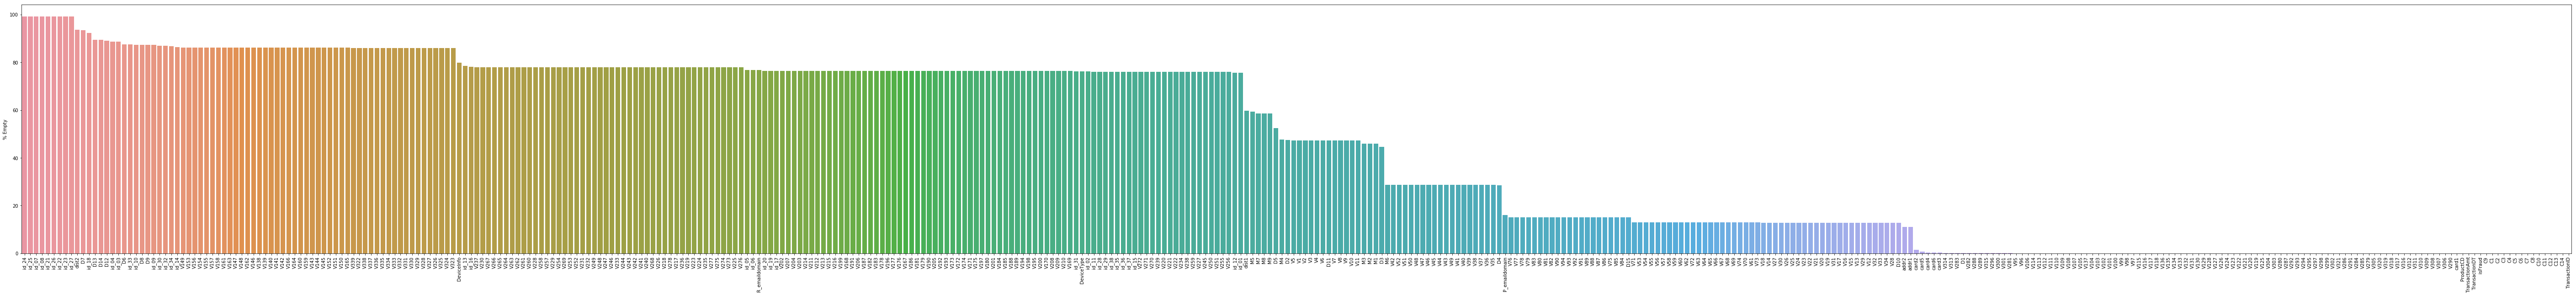

In [18]:
# Visualising the percentage of empty data in each column
plt.figure(figsize = (100,10))
plt.xticks(rotation=90)
fig1 = sns.barplot(x=train_df_nan.index,y =train_df_nan['% Empty'])
fig1;

## Feature Selection

For feature selection, we shall drop every column that is more than 40% empty

The remaining columns that have less than 25% empty rows, will be filled with the mean of the data.


In [19]:
feature_cols_df = train_df_nan[train_df_nan['% Empty'] <= 25]
validate_feat_cols = validate_df_nan[validate_df_nan['% Empty'] <= 25]
feature_cols_df.shape 
validate_feat_cols.shape

(200, 1)

In [20]:
print('Of the \033[1m\033[94m{}\033[0m columns only \033[1m\033[94m{}\033[0m had less than 25% empty cells and are thus used as features'.format(len(train_df_nan),len(feature_cols_df)))
print('The \033[1m\033[94m{}\033[0m feature columns are: \n\033[1m\033[94m{}\033[0m '.format(len(feature_cols_df),list(feature_cols_df.index)))

Of the 434 columns only 182 had less than 25% empty cells and are thus used as features
The 182 feature columns are: 
['P_emaildomain', 'V76', 'V77', 'V78', 'V79', 'V83', 'V80', 'V81', 'V82', 'V90', 'V94', 'V93', 'V92', 'V91', 'V89', 'V88', 'V87', 'V86', 'V75', 'V85', 'V84', 'D15', 'V71', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V62', 'V72', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V74', 'V70', 'V61', 'V73', 'V18', 'V14', 'V27', 'V30', 'V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 'V31', 'V17', 'V16', 'V15', 'V13', 'V29', 'V12', 'V32', 'V33', 'V34', 'V28', 'D10', 'addr2', 'addr1', 'card2', 'card5', 'card4', 'card6', 'card3', 'V314', 'V313', 'V283', 'D1', 'V282', 'V288', 'V289', 'V315', 'V296', 'V300', 'V301', 'V281', 'V95', 'V96', 'V106', 'V114', 'V113', 'V112', 'V111', 'V110', 'V109', 'V108', 'V107', 'V105', 'V137', 'V104', 'V103', 'V102', 'V101', 'V100', 'V99', 'V98', 'V97', 'V115', 'V116', 'V117', 'V118', 'V136', 'V135', 'V134', 'V133', 'V132', 'V1

In [21]:
feat_cols = list(feature_cols_df.index) # Feature colummns as a list
valid_cols = ['P_emaildomain', 'V76', 'V77', 'V78', 'V79', 'V83', 'V80', 'V81', 'V82', 'V90', 'V94', 'V93', 'V92', 'V91', 'V89', 'V88', 'V87', 'V86', 'V75', 'V85', 'V84', 'D15', 'V71', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V62', 'V72', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V74', 'V70', 'V61', 'V73', 'V18', 'V14', 'V27', 'V30', 'V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 'V31', 'V17', 'V16', 'V15', 'V13', 'V29', 'V12', 'V32', 'V33', 'V34', 'V28', 'D10', 'addr2', 'addr1', 'card2', 'card5', 'card4', 'card6', 'card3', 'V314', 'V313', 'V283', 'D1', 'V282', 'V288', 'V289', 'V315', 'V296', 'V300', 'V301', 'V281', 'V95', 'V96', 'V106', 'V114', 'V113', 'V112', 'V111', 'V110', 'V109', 'V108', 'V107', 'V105', 'V137', 'V104', 'V103', 'V102', 'V101', 'V100', 'V99', 'V98', 'V97', 'V115', 'V116', 'V117', 'V118', 'V136', 'V135', 'V134', 'V133', 'V132', 'V131', 'V130', 'V129', 'V128', 'V127', 'V126', 'V124', 'V123', 'V122', 'V121', 'V120', 'V119', 'V125', 'V304', 'V303', 'V280', 'V287', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299', 'V302', 'V321', 'V286', 'V291', 'V284', 'V285', 'V279', 'V305', 'V320', 'V319', 'V318', 'V317', 'V316', 'V312', 'V311', 'V310', 'V309', 'V308', 'V307', 'V306', 'V290', 'card1', 'ProductCD', 'TransactionAmt', 'TransactionDT', 'C9', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 'TransactionID'] 
tx_df = train_df[feat_cols]
vx_df = validate_df[valid_cols]
print('Training Dataset Shape: {}\nValidating Dataset Shape{}'.format(tx_df.shape,vx_df.shape))

Training Dataset Shape: (590540, 182)
Validating Dataset Shape(506691, 181)


## Handling empty cells and Categorical values


In [0]:
tx_df = tx_df.fillna(tx_df.mode()) # Filling empty cells with the most common number for each column
tx_df = tx_df.dropna()


In [0]:
vx_df = vx_df.fillna(vx_df.mode())
vx_df = vx_df.fillna(0)



In [24]:
tx_df.head(3)

,P_emaildomain,V76,V77,V78,V79,V83,V80,V81,V82,V90,V94,V93,V92,V91,V89,V88,V87,V86,V75,V85,V84,D15,V71,V53,V54,V55,V56,V57,V58,V59,V60,V62,V72,V63,V64,V65,V66,V67,V68,V69,...,V321,V286,V291,V284,V285,V279,V305,V320,V319,V318,V317,V316,V312,V311,V310,V309,V308,V307,V306,V290,card1,ProductCD,TransactionAmt,TransactionDT,isFraud,C9,C1,C2,C3,C4,C5,C6,C7,C8,C10,C11,C12,C13,C14,TransactionID
0,gmail.com,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,1.0,13926,W,68.5,86400,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2987000
1,gmail.com,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2755,W,29.0,86401,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2987001
2,outlook.com,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,315.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4663,W,59.0,86469,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2987002


In [25]:
categorical_features = tx_df.select_dtypes(include=['object'])
tx_df_u = tx_df.drop(columns=categorical_features)
vx_df_u = vx_df.drop(columns=categorical_features)
print('Training Comparison: Old Shape{} vs New Shape{}'.format(tx_df.shape,tx_df_u.shape))
print('Validating Comparison: Old Shape{} vs New Shape{}'.format(vx_df.shape,vx_df_u.shape))

Training Comparison: Old Shape(346887, 182) vs New Shape(346887, 178)
Validating Comparison: Old Shape(506691, 181) vs New Shape(506691, 177)


## Basic Visualisations

No handles with labels found to put in legend.


2.0007% of the data is Fraud while 
97.999% of the data is Not Fraud


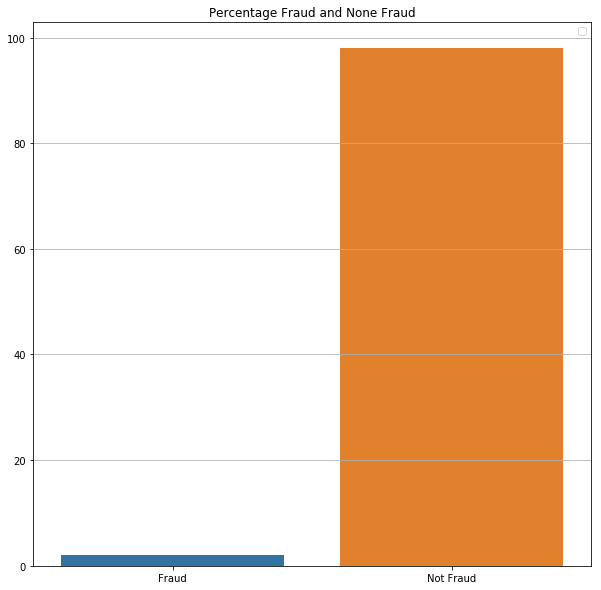

In [36]:
# Ploting Fraud and None Fraud percentages for Training Data
Fraud = ((len(tx_df_u[tx_df_u['isFraud'] ==1]))/len(tx_df_u))*100
Not_Fraud = ((len(tx_df_u[tx_df_u['isFraud'] ==0]))/len(tx_df_u))*100
print ('\033[1m\033[94m{:.5}%\033[0m of the data is Fraud while \n\033[1m\033[94m{:.5}%\033[0m of the data is Not Fraud'.format(Fraud, Not_Fraud))
xx = ['Fraud','Not Fraud']
yy = [Fraud, Not_Fraud]
plt.figure(figsize = (10,10))
plt.grid()
plt.legend()
plt.title('Percentage Fraud and None Fraud')
fig2 = sns.barplot(x=xx,y=yy)
fig2;

CPU times: user 24.3 s, sys: 328 ms, total: 24.6 s
Wall time: 24.3 s


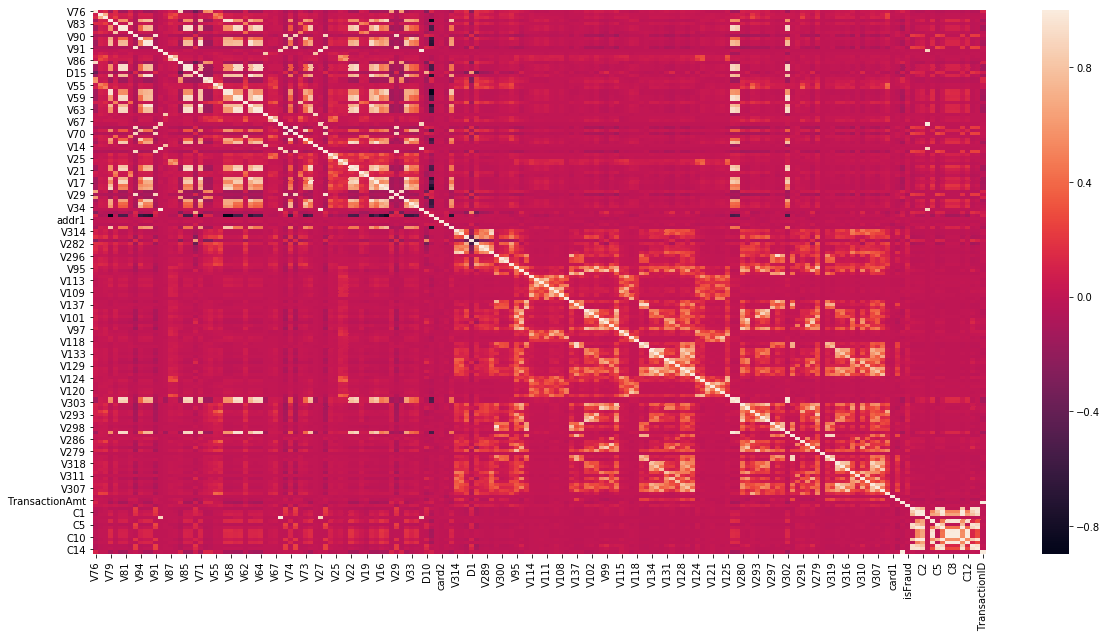

In [40]:
# Plotting the data correlation for training data
%%time
fig3 = sns.heatmap(tx_df_u.corr())
fig3;

# **Modeling the Data**

In [28]:
# Spliting the training data into training and testing data
# The Test data that was provided would be used as a validation dataset, 
# however for this Home Work only the training data is used hence the 75% - 25% train test split. 
X = tx_df_u.drop('isFraud',axis=1)
y = tx_df_u['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)
print ('Train Data size: {}\nTrain Data result: {}\nTest data size: {}\nTest data result: {}'.format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

Train Data size: (260165, 177)
Train Data result: (260165,)
Test data size: (86722, 177)
Test data result: (86722,)


In [29]:
# Logistic Regression Model Data

log_model = LogisticRegression(solver = 'lbfgs')
log_model.fit(X_train, y_train)
print('The model {:.5}% fits the training data'.format(log_model.score(X_train, y_train)*100))

The model 97.968% fits the training data


In [30]:
y_pred = log_model.predict(X_test)
print('\nMean Absolute Error: \033[1m\033[94m{:.5}%\033[0m'.format(metrics.mean_absolute_error(y_test, y_pred)*100))  
print('Mean Squared Error: \033[1m\033[94m{:.5}%\033[0m'.format(metrics.mean_squared_error(y_test, y_pred)*100))  
print('Root Mean Squared Error: \033[1m\033[94m{:.5}%\033[0m'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred)*100)))



Mean Absolute Error: 2.0848%
Mean Squared Error: 2.0848%
Root Mean Squared Error: 1.4439%


**Best on the results above, the model is able to predict whether the Transaction is a fraud or not with 98% precision**

# **Validating the Data**

Since we don't have the final results of the Test data, We can only predict what the results would be. 

In [0]:
v_pred = log_model.predict(vx_df_u)


In [32]:
# Submission needs to be similar to sample df
display(sample_df.head(5))
print('',sample_df.shape)
v_pred_df = pd.DataFrame({'TransactionID':vx_df_u['TransactionID'], 'isFraud':v_pred})
display(v_pred_df.head(5))
print('',v_pred_df.shape)

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


 (506691, 2)


,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0


 (506691, 2)


No handles with labels found to put in legend.


0.10381% of the data is Fraud while 
99.896% of the data is Not Fraud


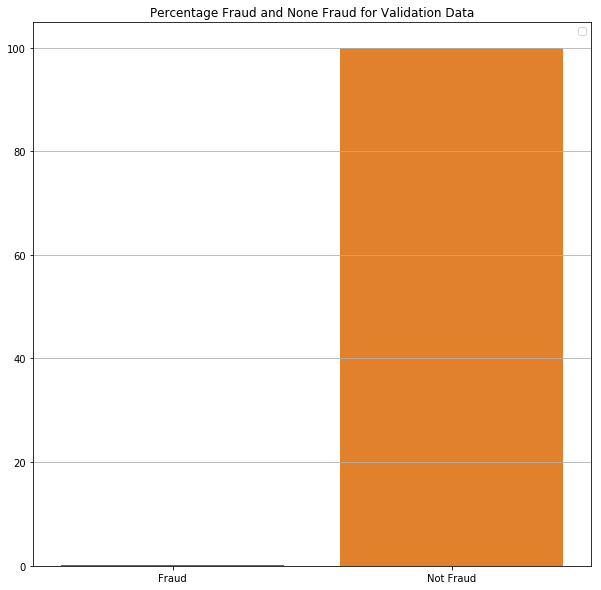

In [41]:
#  The data for validation has been made similar to the sample data.
# Visualising the Validation Fraud data 
Vx_Fraud = ((len(v_pred_df[v_pred_df['isFraud'] ==1]))/len(v_pred_df))*100
Vx_Not_Fraud = ((len(v_pred_df[v_pred_df['isFraud'] ==0]))/len(v_pred_df))*100
print ('\033[1m\033[94m{:.5}%\033[0m of the data is Fraud while \n\033[1m\033[94m{:.5}%\033[0m of the data is Not Fraud'.format(Vx_Fraud, Vx_Not_Fraud))
vx = ['Fraud','Not Fraud']
vy = [Vx_Fraud, Vx_Not_Fraud]
plt.figure(figsize = (10,10))
plt.grid()
plt.legend()
plt.title('Percentage Fraud and None Fraud for Validation Data')
fig4 = sns.barplot(x=vx,y=vy)
fig4;

In [0]:
v_pred_df.to_csv(path+'Fraud_Prediction.csv', index = False)

**The Validation test score on submitting through Kaggle was: 49.93%**

In order to improve the results, better data cleaning and optimisation would be required.
Some of the droped rows, could have outliers that would help the model with better prediction

Comparing with different training models and tuning of hyper parameters would also improve the score.

For the training of this model, given the 98% fit of the training data, there was over fitting by the model. This causes it to fail when faced with totally new data.

In [0]:
# fig2.figure.savefig(path+'FraudinTraining.jpg')

In [0]:
# fig3.figure.savefig(path+'CorrTraining.jpg')

In [0]:
# fig1.figure.savefig(path+'NaNTraining.jpg')